In [1]:
%load_ext autoreload
%autoreload 2
%run prerun.py
%matplotlib inline

device = torch.device('cuda:3')

SOLVERS:  ['dopri5', 'bdf', 'rk4', 'midpoint', 'adams', 'explicit_adams', 'fixed_adams']
{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


## Data

In [2]:
import pandas as pd
df = pd.read_csv('../xz_magnet_opt.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
df.head()

,start_px,start_py,start_pz,pid,hit_x,hit_y,hit_z,hit_E,magn_len,magn_x,start_theta,start_phi,start_P
0,0.585307,-0.239336,7.729657,-13.0,-103.602234,-4.812062,-13000.0,0.865171,5.0,7.0,0.081627,-0.388161,7.755479
1,0.860176,-1.341563,3.837597,-13.0,0.000000,0.000000,0.0,0.000000,5.0,7.0,0.393601,-1.000650,4.155339
2,-1.175180,1.289560,8.766644,-13.0,-752.243652,345.333649,-13000.0,1.663801,5.0,7.0,0.196450,2.309821,8.938572
3,-1.681919,0.904257,9.074683,-13.0,-626.921997,206.969193,-13000.0,1.901685,5.0,7.0,0.207404,2.648293,9.273425
4,0.773998,3.037582,7.728539,-13.0,110.676453,959.350342,-13000.0,2.972845,5.0,7.0,0.385319,1.321298,8.340042


In [4]:
df.shape

(252000, 13)

In [5]:
x_columns = ['hit_x', 'hit_y', 'hit_E']
conditions_columns = ['magn_x', 'magn_len', 'start_pz', 
                      'start_phi', 'start_P', 'start_theta', 
                      'start_px', 'start_py']

In [6]:
x = torch.tensor(df[x_columns].values).float() 
conditions = torch.tensor(df[conditions_columns].values).float()

In [7]:
x.shape, conditions.shape

(torch.Size([252000, 3]), torch.Size([252000, 8]))

## Define model

In [8]:
regularization_fns = None
# regularization_fns, regularization_coeffs = create_regularization_fns()

model = build_model_tabular(dims=x.shape[1], 
                            condition_dim=conditions.shape[1],
                            layer_type='concat_v2',
                            num_blocks=3,
                            rademacher=False,
                            nonlinearity='tanh',
                            solver='dopri5',
                            hidden_dims=(256, 256),
                            bn_lag=0.01, 
                            batch_norm=True,
                            regularization_fns=regularization_fns).to(device)
sum(p.numel() for p in model.parameters()  if p.requires_grad)

257910

In [9]:
import torch.utils.data as pytorch_data_utils
BATCH_SIZE = 16384 * 2
dataset = torch.utils.data.TensorDataset(x, conditions)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training

iter 148: loss = 11.051 0.0001


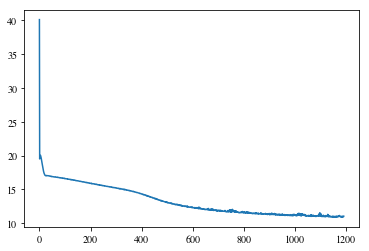

In [ ]:
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(model.parameters()) 
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

B = 5000
for epoch in tqdm(range(50000)):
    for x_batch, cond_batch in tqdm(dataloader):
        x_batch = x_batch.to(device)
        cond_batch = cond_batch.to(device)

        loss = compute_loss(model, data=x_batch + torch.randn(*x_batch.size()).float().to(device), condition=cond_batch)

        if loss != loss:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    clear_output()
    print('iter %s:' % epoch, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
    plt.figure()
    plt.plot(losses)
    # plt.ylim(1.1, 3)
    plt.show()

## Evalutation

In [11]:
model.eval();
sample_fn, density_fn = get_transforms(model)

In [12]:
samples = sample_fn(torch.randn((len(conditions), 3)).float().to(device), conditions.to(device))

In [26]:
torch.unique(conditions[:, 0])

tensor([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [27]:
torch.unique(conditions[:, 1])

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

In [43]:
mask = ((conditions[:, 0] == 1) & (conditions[:, 1] == 1) & (samples[:, 2] > 0.01).detach().cpu()).numpy()

In [44]:
mask.sum()

2000

In [45]:
samples_batch = samples[mask].detach().cpu().numpy()

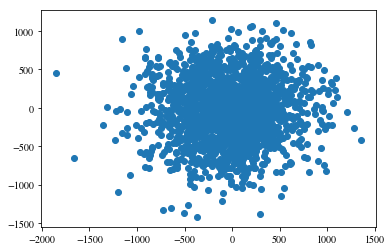

In [46]:
plt.scatter(samples_batch[:, 0], samples_batch[:, 1])

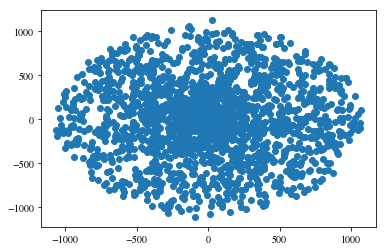

In [47]:
plt.scatter(x[:, 0][mask], x[:, 1][mask])